# Square Separation Non-Binary Pixels #

In this note book I'll look into achieving this
<hr>
https://trello-attachments.s3.amazonaws.com/55c113812dfbd4e8f6dbd41d/1024x768/eac008a9e47f4d80a006f987122ef805/photo.jpg
<hr>
That is One model trained on 50% opacity squares. Then the composite image is two of those overlayed such that their opacity is now 1 where they overlap!

In [4]:
from scipy.special import expit
from rbmpy.rbm import RBM
from rbmpy.sampler import VanillaSampler,ContinuousApproxSampler, ContinuousSampler,PartitionedSampler, ApproximatedSampler, LayerWiseApproxSampler,ApproximatedMulDimSampler
from rbmpy.trainer import VanillaTrainier
from rbmpy.performance import Result
import numpy as np
import rbmpy.datasets, rbmpy.performance, rbmpy.plotter, rbmpy.mnist, pickle, rbmpy.rbm, os, logging, rbmpy.sampler,math
from sklearn.linear_model import Perceptron
from sklearn.neural_network import BernoulliRBM
import rbmpy.plotter as pp
from numpy import newaxis
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

logger = logging.getLogger()
# Set the logging level to logging.DEBUG 
logger.setLevel(logging.INFO)


%matplotlib inline
from IPython.core.debugger import Tracer; debug_here = Tracer()
# Helper Methods
def squash_images(imgs):
    squashed = np.array(imgs)
    old_shape = squashed.shape
    squashed = squashed.reshape(old_shape[0], old_shape[1] * old_shape[2])
    return squashed

def inflate_images(imgs):
    inflated = np.array(imgs)
    old_shape = inflated.shape
    size= math.sqrt(old_shape[1])
    inflated = inflated.reshape(old_shape[0], size, size)
    return inflated
def gen_square(xy,sq_shape, img_size, pixel_value = 1):
    """Square image starting at i, of sq_size within img_size. i must be < (sq_size + img_size)"""
    img = np.zeros(img_size)
    x = xy[0]
    y = xy[1]
    x2 = x + sq_shape[0]
    y2 = y + sq_shape[1]
    img[x:x2,y:y2] = pixel_value
    return img
def gen_training(sq_shape, img_size, pixel_value):
    if img_size[0] != img_size[1]:
        logger.warn("Unsquashing will not work with none squares yet!")
    training = []
    for x in range(img_size[0]-1):
        for y in range(img_size[1]-1):
            training.append(gen_square((x,y), sq_shape, img_size,pixel_value))
    return np.array(training)
    
def ll_score(v, v_prime):
    if v == 0.5:
        return np.log(v_prime)
    elif v == 0:
        return np.log(1 - v_prime)
    else:
        raise NotImplementedError()
ll_score = np.vectorize(ll_score)

def evaluate_model(training, model):
    s = VanillaSampler(model)
    results = []
    avg = 0
    for i in range(5000):
        results.append(ll_score(squash_images(train),s.reconstruction_given_visible(squash_images(train), return_sigmoid=True)).sum())
    avg = avg/i
    npr = np.array(results)
    return npr
   # return np.median(npr,axis=0), np.min(npr, axis = 0), np.max(npr,axis = 0), np.mean(npr,axis = 0)
    
    
def plot_eval(train,model):
    # look at the reconstructions
    dreams = []
    for i in range(16):
        dreams.append(s.dream(model).reshape(5,5))
    pp.images(np.array(dreams), color_range=(0,1))
    # Lets also look at it's weights
    pp.images(rbm.weights_into_hiddens(model.weights)[:10], cmap='Greys',title= "Hinton Diagrams",filename="Results/Weights.png")
    result = evaluate_model(train,model)
    plt.plot(result)
    plt.show()
    print("mean{:.2f} Worst {:.2f} Best {:.2f}".format( np.mean(result), np.min(result), np.max(result)))
    pp.images(inflate_images(squash_images(train) - s.reconstruction_given_visible(squash_images(train))))

In [2]:
train = gen_training((2,2),(5,5),pixel_value = 0.5)

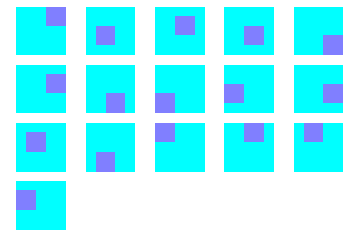

In [3]:
np.random.shuffle(train)
pp.images(train, title="Training Set", color_range=(0,1))

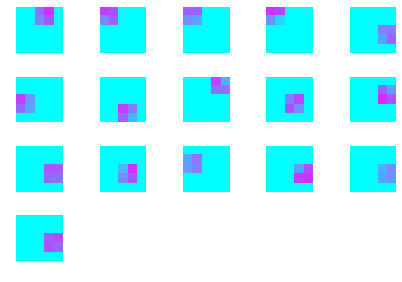

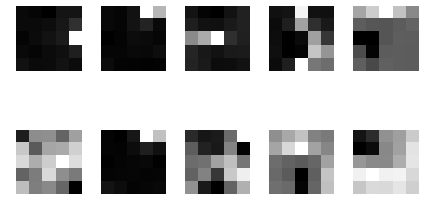

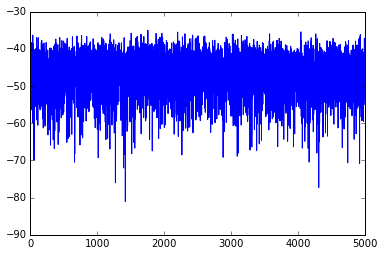

mean-46.84 Worst -81.06 Best -35.00


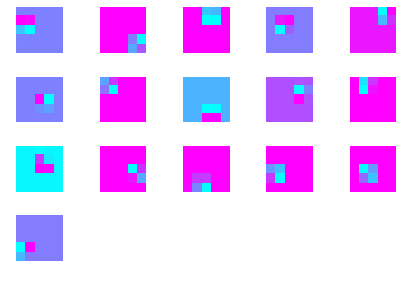

In [20]:
model = RBM(25,25,16)
s = ContinuousSampler(model)
t = VanillaTrainier(model, s)
t.train(400000, squash_images(train), learning_rate=0.005)
# plot the 16 centers
plot_eval(train, model)

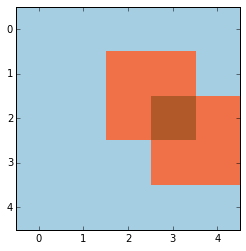

In [41]:
data = model.visible.copy()
np.random.shuffle(data)
item_one = inflate_images(data)[0]
item_two = inflate_images(data)[1]
composite_v = item_one +item_two
pp.image(item_one+ item_two,cmap='Paired',show_colorbar=False,color_range=(0,1))

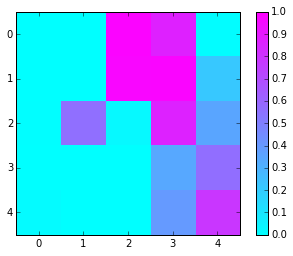

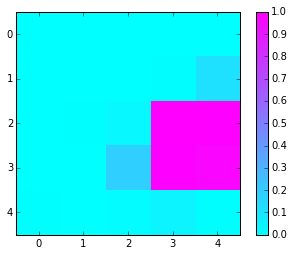

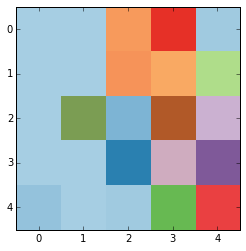

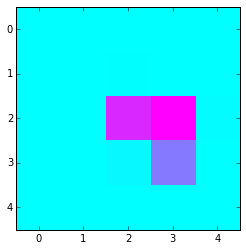

In [52]:
rand_h = np.random.randint(0,2,25)
approx= ContinuousApproxSampler(model.weights, model.weights, model.hidden_bias, model.hidden_bias)
reconstruction = approx.v_to_v(rand_h,rand_h, composite_v.reshape(25),num_gibbs=100000)
pp.image(reconstruction[0].reshape(5,5),show_colorbar=True, title="V'_a",color_range=(0,1))
pp.image(reconstruction[1].reshape(5,5), show_colorbar=True, title = "V'_b",color_range=(0,1))
pp.image(reconstruction[0].reshape(5,5) + reconstruction[1].reshape(5,5),title="Composite Recon" ,cmap ='Paired',show_colorbar=False)
pp.image(s.reconstruction_given_visible(composite_v.reshape(25)).reshape(5,5),show_colorbar=False)

In [11]:
def gen_composite_training(sq_shape, img_size, static_xy):
    training = []
    for x in range(img_size[0]-1):
        for y in range(img_size[1]-1):
            training.append(gen_square((x,y), sq_shape, img_size,pixel_value= 0.5) + gen_square(static_xy, sq_shape, img_size,pixel_value=0.5))
    return np.array(training)

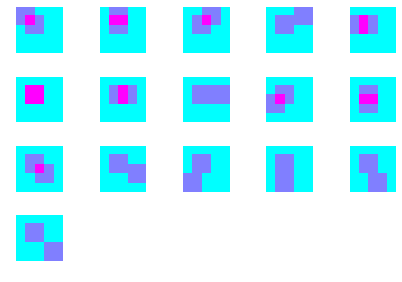

In [12]:
comp = gen_composite_training((2,2),(5,5),(1,1))
pp.images(comp,color_range=(0,1))

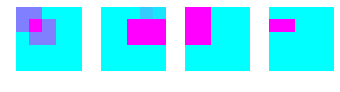

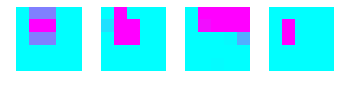

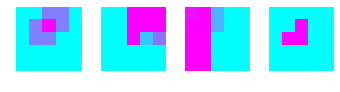

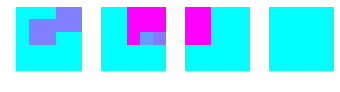

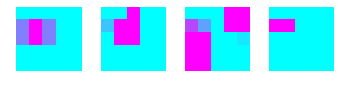

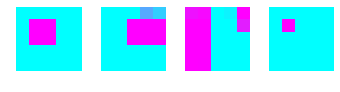

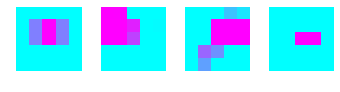

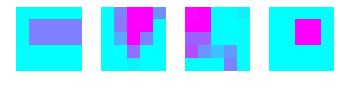

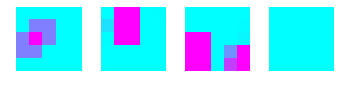

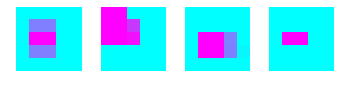

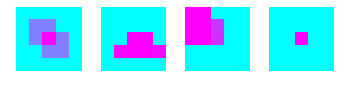

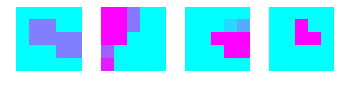

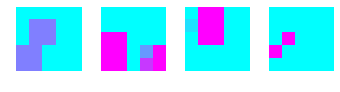

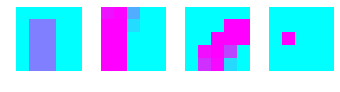

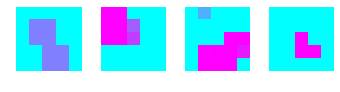

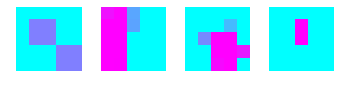

In [19]:
rand_h = np.random.randint(0,2,model.num_hid())
approx= ContinuousApproxSampler(model.weights, model.weights, model.hidden_bias, model.hidden_bias)
s = VanillaSampler(model)
for current_img in comp:
    reconstruction = approx.v_to_v(rand_h,rand_h,current_img.reshape(25),num_gibbs=1000)
    pp.images(
        np.array([current_img,reconstruction[0].reshape(5,5),
                  reconstruction[1].reshape(5,5),
                  s.reconstruction_given_visible(current_img.reshape(25)).reshape(5,5)]),color_range =(0,1))